In [1]:
import os
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.prep.correction as corr
import neutompy as ntp
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import algotom.prep.removal as rem
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
import svmbir

# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
print("CPU cores:", ncore)

CPU cores: 256


# Workflow starts here!

In [2]:
###################### need to change start
ipts="32340"
###################### need to change end

## Find CT scan location

In [3]:
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data"
ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
sorted(os.listdir(ct_loc))

['2024_01_29_stack1',
 '2024_01_30',
 '2024_03_17_lam_Sample1',
 '2024_03_17_lam_Sample1_new',
 '2024_03_17_lam_Sample2',
 '2024_03_17_lam_Sample2_new',
 '2024_03_17_laminography_S1',
 '2024_03_17_laminography_S2',
 '2024_04_09_lam_S3']

## Find OB location

In [4]:
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data"
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
sorted(os.listdir(ob_loc))

['2024_01_29_stack1',
 '2024_01_30',
 '2024_03_17_laminography_S1',
 '2024_04_09_lam_S3']

## Find DC location

In [5]:
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data"
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/dc"
# dc_loc = "/HFIR/CG1D/IPTS-32298/raw/dc"
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
sorted(os.listdir(dc_loc))

['2024_01_21_45s', '2024_01_30', '2024_03_17_lam_align', '2024_04_09_lam_S3']

In [6]:
###################### need to change start
sample_name = "2024_03_17_laminography_S2"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2024_03_17_laminography_S1")
dc_dir = os.path.join(dc_loc, "2024_03_17_lam_align")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
###################### need to change end
gamma_diff = 20
img_per_ang = 1
mars_ct = True
# mars_ct = False
filter_name = None  # can be used to seperate 2 CTs in the same folder
end_ang = 360 # Will *NOT* be used if the CT file names contain angle info
ct_name = "*projection*" # Will not be used if follows the default file structure
ob_name = "*OB*" # Will not be used if follows the default file structure
dc_name = "*DC*" # Will not be used if follows the default file structure
svmbir_path = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/svmbir/"

# Load all data files (CT, OB and DC)

In [7]:
history_dict = {}
######### CT
proj_raw, ang_deg, ang_rad, proj180_idx, proj000_idx, fname_sorted = rocku.load_ct(ct_dir, ang2=end_ang, name=ct_name, 
                                                                                   filter_name=filter_name, img_per_ang=img_per_ang,
                                                                                  mars_ct=mars_ct)
######### OB
ob_raw = rocku.load_ob(ob_dir, name=ob_name)
######### DC
dc_raw = rocku.load_dc(dc_dir, name=dc_name)

Normal CT naming convention
735


Found index of 180 degree projections: 367 of angle 179.83
Found index of 0 degree projections: 0 of angle 0.0
Loading 735 CT projections...
735 CT projections loaded!
Shape: (735, 2048, 2048)
Loading 5 Open Beam (OB) images...
5


5 Open Beam (OB) images loaded!
Shape: (5, 2048, 2048)
Loading 5 Dark Current (DC) images...
5


5 Dark Current (DC) images loaded!
Shape: (5, 2048, 2048)


# Visual verification of loaded files

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integerError.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

Time: 0.23653631005436182 s


Text(0.5, 1.0, 'Ratio')

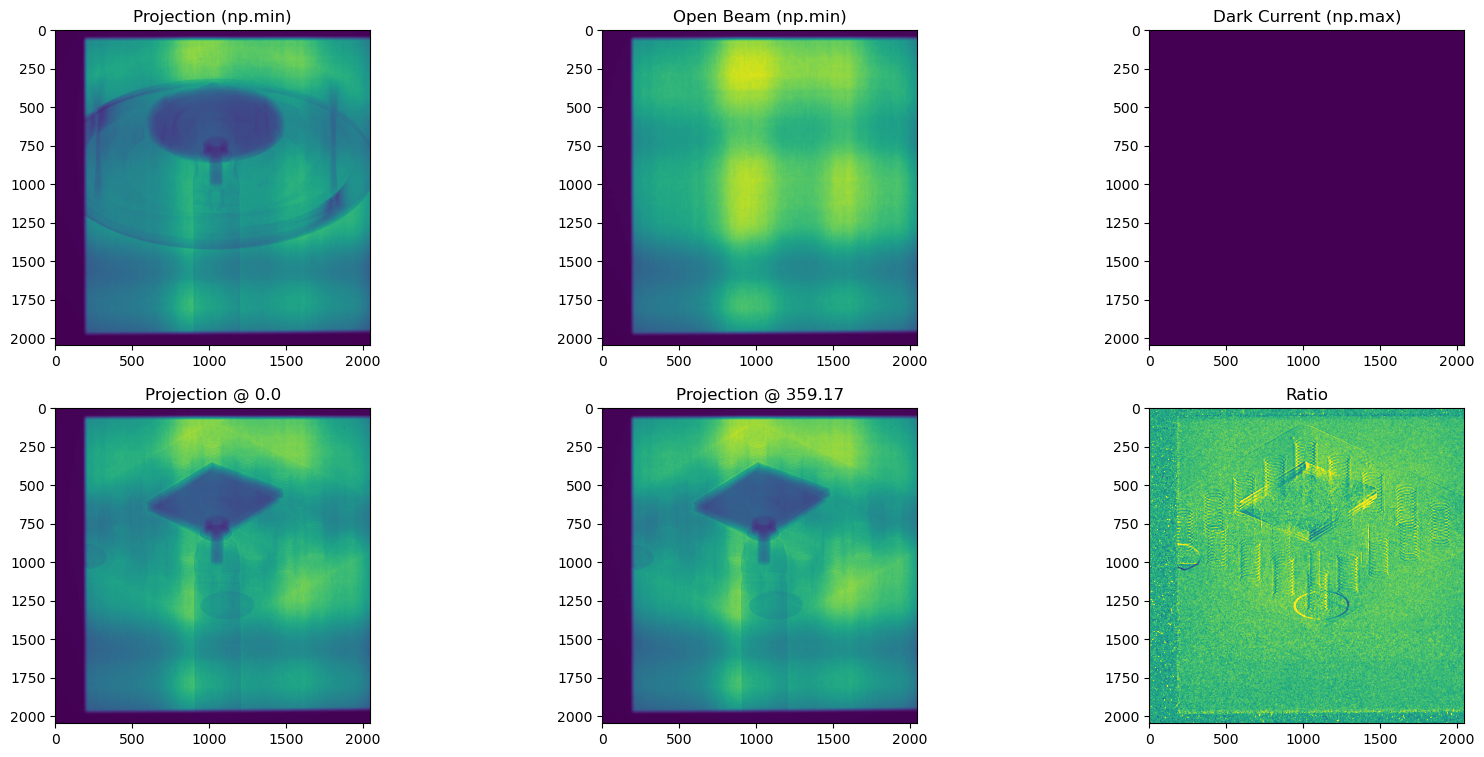

In [8]:
vmax = tomopy.misc.corr.remove_outlier(ob_raw[0], gamma_diff, ncore=ncore).astype(np.ushort).max()
vmin = tomopy.misc.corr.remove_outlier(proj_raw[0], gamma_diff, ncore=ncore).astype(np.ushort).min()
##################
t0 = timeit.default_timer()
proj_min = np.min(proj_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
proj360_idx = proj180_idx*2-1
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
f, ax = plt.subplots(2, 3, figsize=(20, 9))
ax[0][0].imshow(proj_min, vmax=vmax, vmin=vmin)
ax[0][0].set_title('Projection (np.min)')
ax[0][1].imshow(ob_min, vmax=vmax, vmin=vmin)
ax[0][1].set_title('Open Beam (np.min)')
ax[0][2].imshow(dc_max, vmax=vmin+1000, vmin=vmin)
ax[0][2].set_title('Dark Current (np.max)')
ax[1][0].imshow(proj_raw[0], vmax=vmax, vmin=vmin)
ax[1][0].set_title('Projection @ {}'.format(ang_deg[0]))
ax[1][1].imshow(proj_raw[proj360_idx], vmax=vmax, vmin=vmin)
ax[1][1].set_title('Projection @ {}'.format(ang_deg[proj360_idx]))
ax[1][2].imshow(proj_raw[proj360_idx]/proj_raw[0], vmax=1.1, vmin=0.9)
ax[1][2].set_title('Ratio')

# Resize/crop

Cropped:


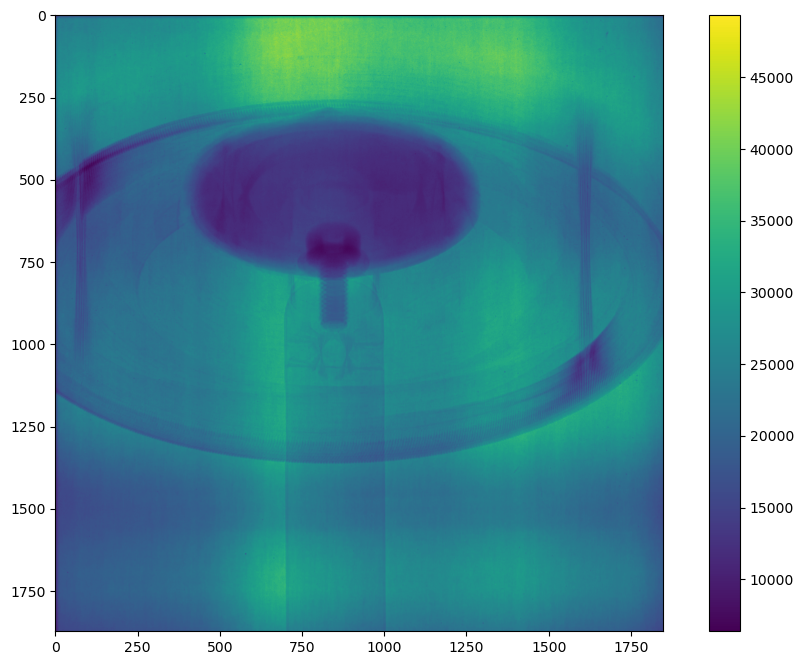

In [11]:
###################### need to change start
# crop = False
crop = True

crop_left = 200#950
crop_right = -1#3850
###################### need to change end
crop_top = 65
crop_bottom = -110
proj_crop = rocku.crop(proj_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
proj_crop_min = rocku.crop(proj_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Cropped:")
plt.imshow(proj_crop_min, vmax=vmax)
plt.colorbar()
plt.show()
crop_roi_dict = {
    'left': crop_left,
    'right': crop_right,
    'top': crop_top,
    'bottom': crop_bottom
}
history_dict = rocku.log(history_dict, 'crop', crop)
if crop:
    history_dict = rocku.log(history_dict, 'crop_roi_dict', crop_roi_dict)

# Remove Outliers

In [12]:
t0 = timeit.default_timer()
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, gamma_diff, ncore=ncore).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff, ncore=ncore).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff, ncore=ncore).astype(np.ushort)
# proj_crop = tomopy.misc.corr.remove_outlier_cuda(proj_crop, gamma_diff).astype(np.ushort)
# ob_crop = tomopy.misc.corr.remove_outlier_cuda(ob_crop, gamma_diff).astype(np.ushort)
# dc_crop = tomopy.misc.corr.remove_outlier_cuda(dc_crop, gamma_diff).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
history_dict = rocku.log(history_dict, 'gamma_filter', True)
history_dict = rocku.log(history_dict, 'gamma_diff', gamma_diff)

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

Time: 5.952515515964478 s


# Rebin Pixels

In [13]:
pixel_bin_size = 1
# pixel_bin_size = 2
func = np.sum
# dtype = np.float16
dtype = np.float32
# dtype = np.float64
#################################################
t0 = timeit.default_timer()
proj_crop_resized = rocku.bin_pix(proj_crop, pixel_bin_size=pixel_bin_size, func=func, dtype=dtype)
ob_crop_resized = rocku.bin_pix(ob_crop, pixel_bin_size=pixel_bin_size, func=func, dtype=dtype)
dc_crop_resized = rocku.bin_pix(dc_crop, pixel_bin_size=pixel_bin_size, func=func, dtype=dtype)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Pixel_bin_size = 1, no binning
Pixel_bin_size = 1, no binning
Pixel_bin_size = 1, no binning
Time: 0.00017407210543751717 s


# Normalization

OB stack combined by median.
DC stack combined by median.
Normalization Done!
float32
(735, 1873, 1847)
Normalization Time: 2.3990720412693918 s


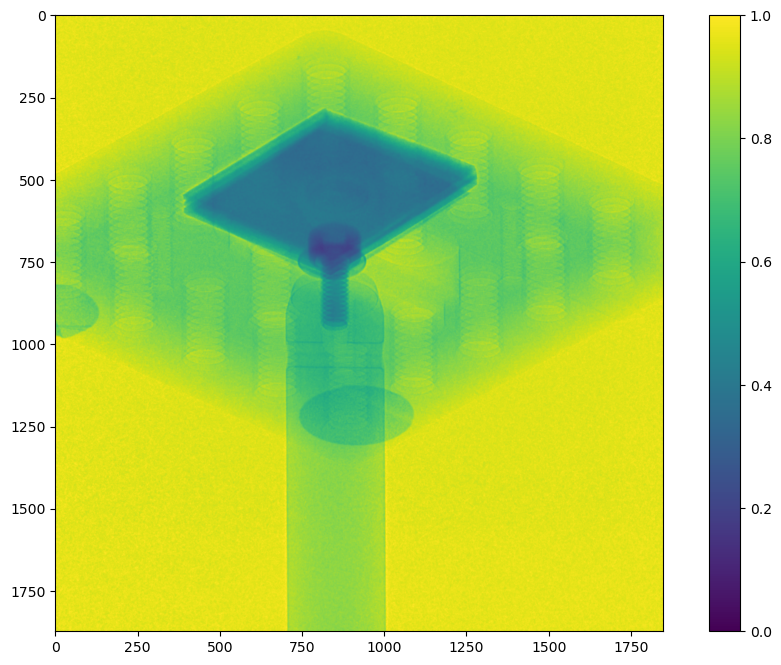

In [14]:
#################################################
t0 = timeit.default_timer()
proj_norm, proj_mi_dc, ob_med, dc_med = rocku.normalize(proj_crop_resized, ob_crop_resized, dc_crop_resized)
print(proj_norm.dtype)
print(proj_norm.shape)
t1 = timeit.default_timer()
print("Normalization Time: {} s".format(t1-t0))
proj_norm = rocku.remove_nan(proj_norm, val=0, ncore=ncore)
proj_norm = rocku.remove_neg(proj_norm, val=0, ncore=ncore)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'normalization', True)
history_dict = rocku.log(history_dict, 'pixel_bin_size', pixel_bin_size)

# Beam fluctuation correction (optional)

Beam fluctuation ROI:


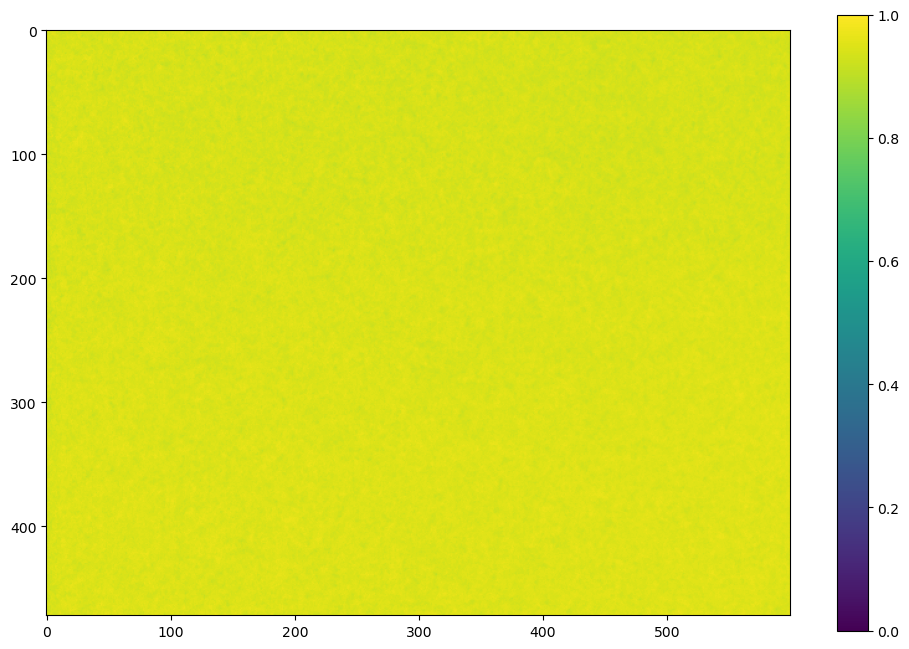

In [15]:
###################### need to change start
fluc_corr = True
# fluc_corr = False
bg_left = 0
bg_right = 600
bg_top = 1400#750
bg_bottom = -1#3000
###################### need to change end
if fluc_corr:
    bg_stack = proj_norm[:, bg_top:bg_bottom, bg_left:bg_right]
    bg_min = np.min(bg_stack, axis=0)
    print("Beam fluctuation ROI:")
    plt.imshow(bg_min, vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

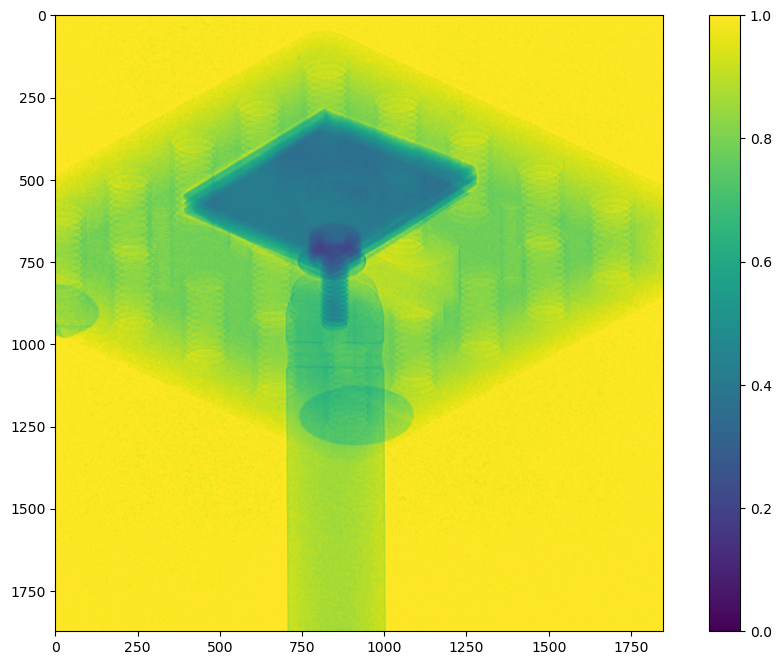

Time: 10.818178938701749 s


In [16]:
if fluc_corr:
    t0 = timeit.default_timer()
    proj_norm = tomopy.prep.normalize.normalize_roi(proj_norm, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
    plt.imshow(proj_norm[0], vmin=0, vmax=1)
    plt.colorbar()
    plt.show()
    t1 = timeit.default_timer()
    print("Time: {} s".format(t1-t0))
    bg_roi_dict = {
        'left': bg_left,
        'right': bg_right,
        'top': bg_top,
        'bottom': bg_bottom
    }
    history_dict = rocku.log(history_dict, 'beam_fluc_corr', fluc_corr)
    history_dict = rocku.log(history_dict, 'beam_fluc_corr_roi_dict', bg_roi_dict)

# Minus log conversion

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)

Minus Log Time: 0.2813277500681579 s


Error.  nthreads must be a positive integer/SNS/users/y9z/miniconda3/envs/rockit/lib/python3.10/site-packages/tomopy/misc/corr.py:747: UserWarning: The tomocuda is not support, using cpu outlier removal
  warnings.warn("The tomocuda is not support, using cpu outlier removal")
Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

Outlier Removal Time: 1.728860101196915 s


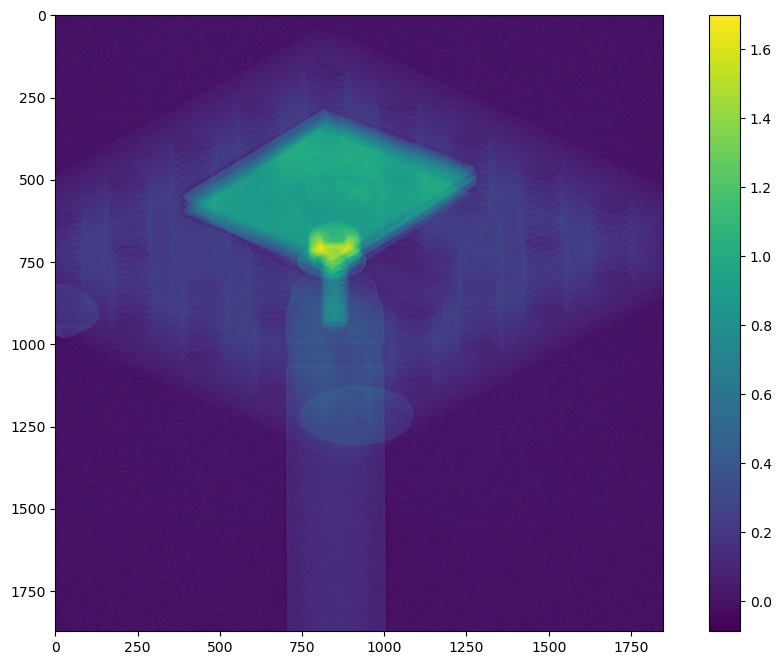

In [17]:
t0 = timeit.default_timer()
# _proj_norm = proj_norm[:]
proj_mlog = tomopy.minus_log(proj_norm, ncore=ncore, out=None)
t1 = timeit.default_timer()
history_dict = rocku.log(history_dict, 'minus_log', True)
print("Minus Log Time: {} s".format(t1-t0))
## Optional to removal outliers again in mlog
mlog_diff = 0.2
t0 = timeit.default_timer()
proj_mlog = tomopy.misc.corr.remove_outlier_cuda(proj_mlog, mlog_diff)
t1 = timeit.default_timer()
print("Outlier Removal Time: {} s".format(t1-t0))
proj_mlog = rocku.remove_neg(proj_mlog, val=0, ncore=ncore)
sino_mlog = np.moveaxis(proj_mlog, 1, 0)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()

# Find and correct tilt

Text(0.5, 1.0, 'Reference')

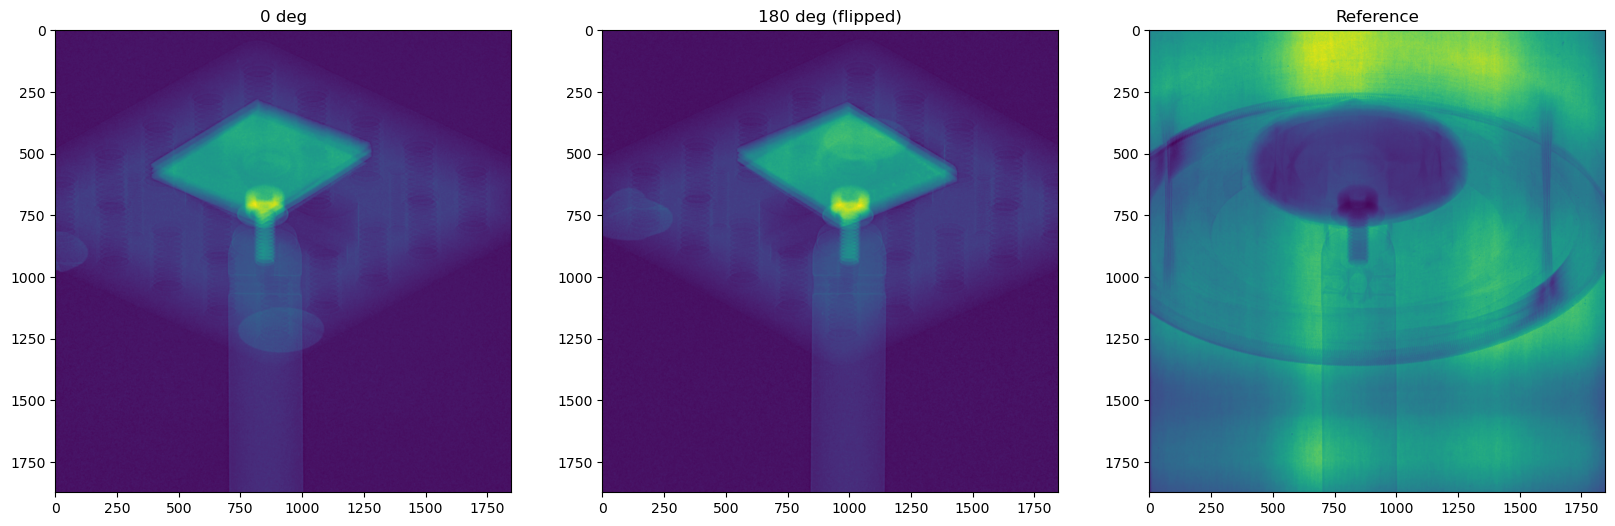

In [18]:
f, ax = plt.subplots(1, 3, figsize=(20, 9))
ax[0].imshow(proj_mlog[proj000_idx])
ax[0].set_title('0 deg')
ax[1].imshow(np.fliplr(proj_mlog[proj180_idx]))
ax[1].set_title('180 deg (flipped)')
ax[2].imshow(proj_crop_min)
ax[2].set_title('Reference')

> Finding the rotation axis position...
> Select ROI 1
ROI selected: ymin = 1420 , ymax = 1859 , xmin = 32 , xmax = 1819
Rotation axis Found!
offset = 76.0    tilt angle = -0.3869136820536429 °
average of residuals  =  0.032999583


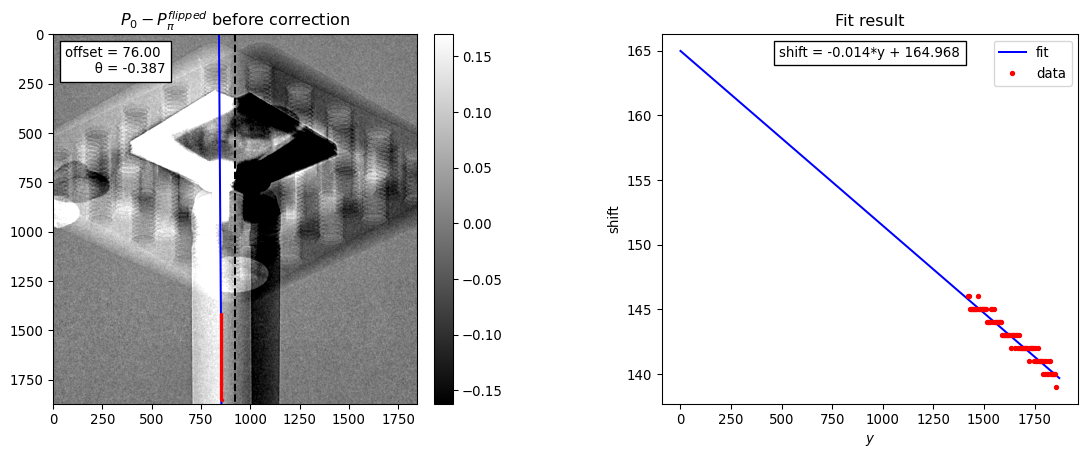

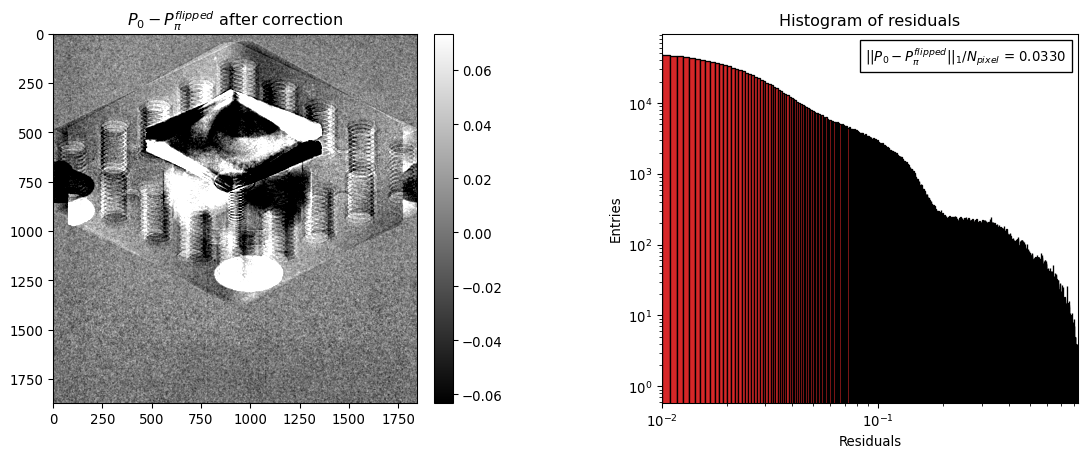

> Correcting rotation axis misalignment...


100%|████████████████████████████████████| 735/735 [00:09<00:00, 80.73 images/s]


In [19]:
# Tilt correction (neutompy)
nroi = 1
use_input = False
# use_input = True
shift_input = 9.0
theta_input = 0.043059415809209155
proj_0 = proj_mlog[proj000_idx]
proj_180 = proj_mlog[proj180_idx]
if use_input:
    tt_offset = shift_input
    tt_ang = theta_input
    # tt_offset = np.float64(shift_input)
    # tt_ang = np.float64(theta_input)
else:
    tt_offset, tt_ang = ntp.find_COR(proj_0=proj_0, proj_180=proj_180, nroi=nroi, ref_proj=proj_crop_min)
proj_mlog_tilt = ntp.correction_COR(norm_proj=proj_mlog, proj_0=proj_0, proj_180=proj_180, shift=tt_offset, theta=tt_ang)
history_dict = rocku.log(history_dict, 'tilt_corr_used', 'neutompy')

# Focused ROI for the next steps

Time: 0.3749042530544102 s


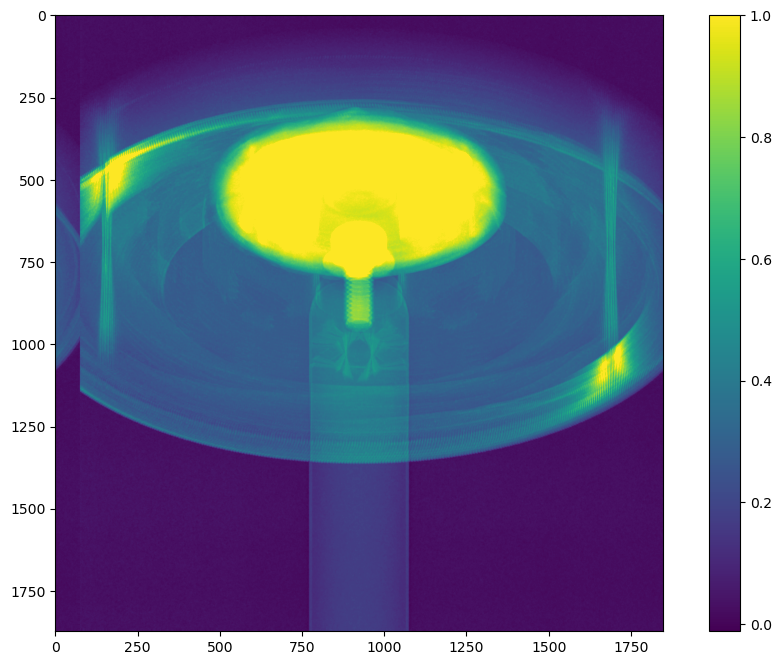

In [26]:
t0 = timeit.default_timer()
proj_mlog_tilt_min = np.max(proj_mlog_tilt, axis=0)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
plt.imshow(proj_mlog_tilt_min, vmax=1)
plt.colorbar()
plt.show()

Defined ROI:


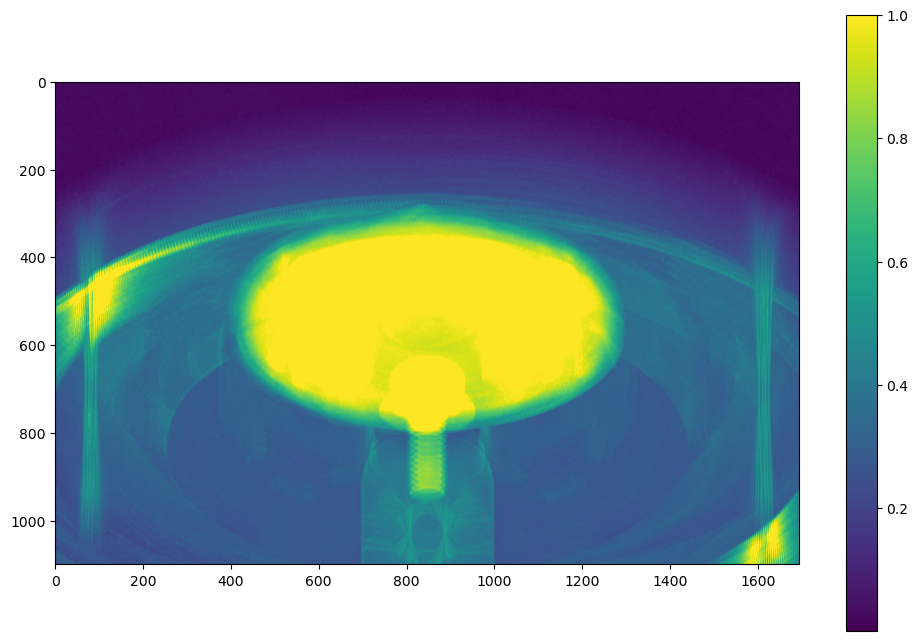

In [28]:
### Define ring removal roi
define_roi = True
# define_roi = False

define_roi_top = 0#270
define_roi_bottom = 1100
############################################
############################################
###################### need to change end
shift = int(abs(tt_offset))
define_roi_left = shift
define_roi_right = -1*shift

proj_mlog_tilt_min_crop = rocku.crop(proj_mlog_tilt_min, define_roi_left, define_roi_right, define_roi_top, define_roi_bottom, define_roi)
proj_mlog_roi = rocku.crop(proj_mlog_tilt, define_roi_left, define_roi_right, define_roi_top, define_roi_bottom, define_roi)
# Covert to sinogram
sino_mlog_roi = np.moveaxis(proj_mlog_roi, 1, 0)

define_roi_dict = {
    'left': define_roi_left,
    'right': define_roi_right,
    'top': define_roi_top,
    'bottom': define_roi_bottom
}
history_dict = rocku.log(history_dict, 'define_roi', define_roi)
if define_roi:
    history_dict = rocku.log(history_dict, 'define_roi_dict', define_roi_dict)
    print("Defined ROI:")
    plt.imshow(proj_mlog_tilt_min_crop, vmax=1)
    plt.colorbar()
    plt.show()

# Test tilt and COR by reconstruct slices

In [29]:
# # Covert to sinogram
# sino_mlog_tilt = np.moveaxis(proj_mlog_tilt, 1, 0)

print("Finding the center of rotation (COR)...")
# Use Vo's approach for 360 sinogram (180sinogram is calc.find_center_vo)
rot_center_180 = calc.find_center_vo(sino_mlog_roi[int(sino_mlog_roi.shape[0]/2)][:proj180_idx], ncore=ncore)
print('Estimated center of rotation (COR) with 180:', rot_center_180)
history_dict = rocku.log(history_dict, 'rot_center_180', rot_center_180)

rot_center_360 = calc.find_center_360(sino_mlog_roi[int(sino_mlog_roi.shape[0]/2)], win_width=800, ncore=ncore)[0]
print('Estimated center of rotation (COR) with 360:', rot_center_360)
history_dict = rocku.log(history_dict, 'rot_center_360', rot_center_360)

Finding the center of rotation (COR)...
Estimated center of rotation (COR) with 180: 833.75
Estimated center of rotation (COR) with 360: 847.5


Center of rotation: 847.5
Tilt theta applied: -0.3869136820536429
Tilt offset applied: 76
Time cost 0.2737465240061283 s


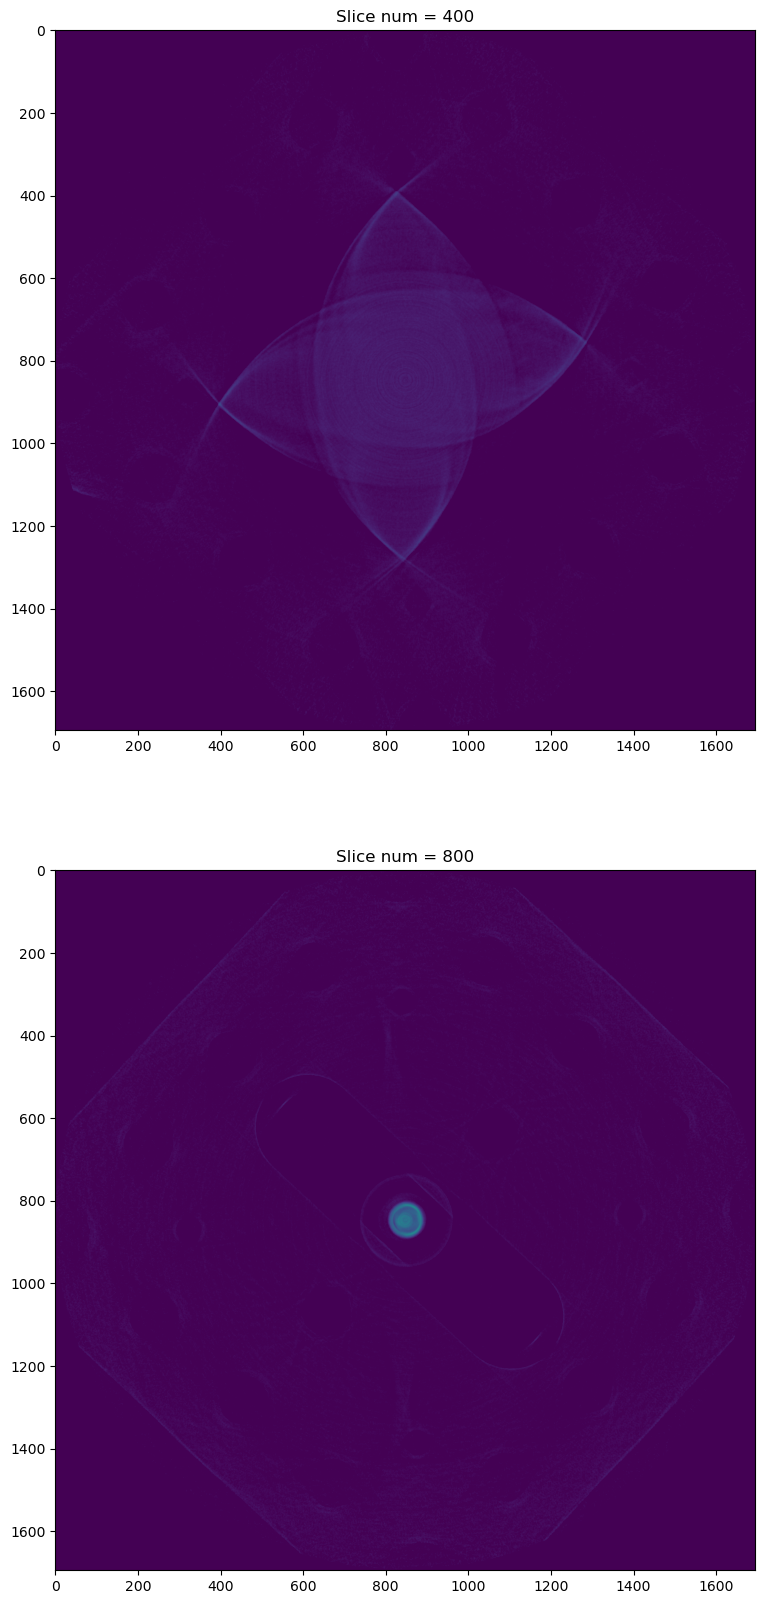

In [30]:
###################### need to change start
slice_idx_list = [400, 800]
# pix_um = None
pix_um = 42 # um
# pix_um = 7.8*pixel_bin_size # um
# pix_um = 15.97*pixel_bin_size # um
# pix_um = 15.97*3 # um
# rot_center = rot_center_180
rot_center = rot_center_360

recon_crop = False
# recon_crop = True
recon_crop_left = 200
recon_crop_right = 1200
recon_crop_top = 200
recon_crop_bottom = 1200
###################### need to change end
######################################
## Recon some slices to check the sharpness
history_dict = rocku.log(history_dict, 'rot_center', rot_center)
print("Center of rotation:", rot_center)
history_dict = rocku.log(history_dict, 'tilt_corr_theta', tt_ang)
print("Tilt theta applied:", tt_ang)
history_dict = rocku.log(history_dict, 'tilt_corr_shift', tt_offset)
print("Tilt offset applied:", tt_offset)
t0 = timeit.default_timer()
f, ax = plt.subplots(len(slice_idx_list), 1, figsize=(20, 20))

for num, e_idx in enumerate(slice_idx_list):
    _rec_img = rec.gridrec_reconstruction(sino_mlog_roi[e_idx], rot_center, angles=ang_rad, 
                                          apply_log=False, ratio=1.0, filter_name='shepp', pad=100,
                                          ncore=ncore
                                     )
    _rec_img = rocku.crop(_rec_img, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    if pix_um is not None:
        pix_cm = pix_um/10000
        _rec_img = _rec_img/pix_cm
    ax[num].imshow(_rec_img, vmin=0, vmax=5)
    ax[num].set_title('Slice num = {}'.format(e_idx))
t1 = timeit.default_timer()
print("Time cost {} s".format((t1-t0)))

In [ ]:
### Optional tests with different slice index
slice_idx_list = [480, 2800]
f, ax = plt.subplots(len(slice_idx_list), 1, figsize=(20, 20))
for num, e_idx in enumerate(slice_idx_list):
    _rec_img = rec.gridrec_reconstruction(sino_mlog_roi[e_idx], rot_center, angles=ang_rad, 
                                          apply_log=False, ratio=1.0, filter_name='shepp', pad=100,
                                          ncore=ncore
                                     )
    _rec_img = rocku.crop(_rec_img, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    if pix_um is not None:
        pix_cm = pix_um/10000
        _rec_img = _rec_img/pix_cm
    ax[num].imshow(_rec_img, vmin=0, vmax=3)
    ax[num].set_title('Slice num = {}'.format(e_idx))

# Ring Artifact Removal

In [32]:
# ring_algo = 'Vo' ######### (a) Vo's approach from tomopy (faster)
# ring_algo = 'bm3d' ######### (b) bm3d approach (slow, but generally better)
ring_algo = 'bm3dgpu' ######### (b) bm3d approach (slow, but generally better)
# ring_algo = 'bm3dornl' ######### (c) bm3dornl GPU
#################################################################################
t0 = timeit.default_timer()
proj_mlog_rmv = rocku.remove_ring(proj_mlog=proj_mlog_roi, ring_algo=ring_algo, ncore=ncore)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'ring_removal', ring_algo)
proj_mlog_to_recon = proj_mlog_rmv.astype(np.float32)
sino_mlog_to_recon = np.moveaxis(proj_mlog_to_recon, 1, 0)

Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
BM3D Streak denoising
(c) 2010-2024 Noiseless Imaging Oy - Tampere, Finland
Version 1.0.0.0
CONFIDENTIAL
COPYRIGHT AND LICENSE NOTICE 

This software is protected by copyright, author rights and/or other intellectual property rights which are the property of Noiseless Imaging Ltd (Tampere, Finland) and/or third parties.
Use of the software is permitted provided that use is for informational purposes and having non-commercial scope only.
No other use of the software and of any information incorporated thereto is hereby authorized.
This copy is for use by Singanallur Venkat

Text(0.5, 1.0, 'Difference')

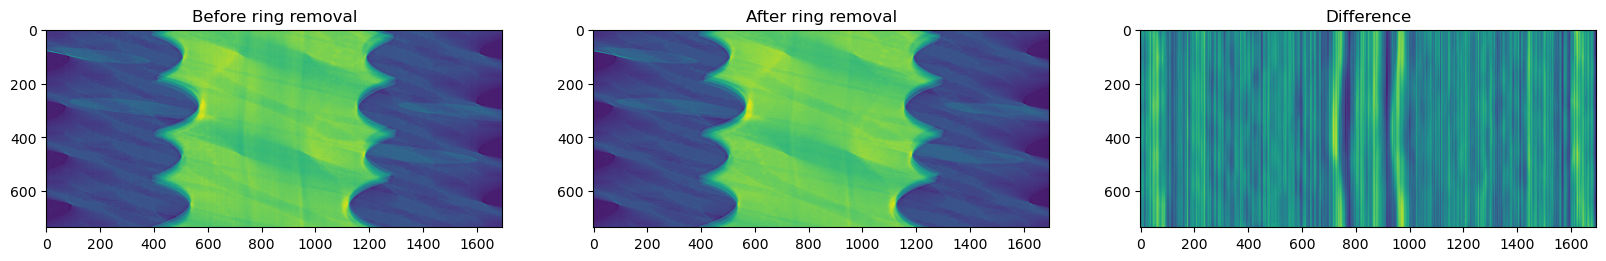

In [33]:
slice_num = None
# slice_num = 140
#######################
if slice_num is None:
    slice_num = int(proj_mlog_roi.shape[1]/2)
f, ax = plt.subplots(1, 3, figsize=(20, 9))
ax[0].imshow(sino_mlog_roi[slice_num])
ax[0].set_title('Before ring removal')
ax[1].imshow(sino_mlog_to_recon[slice_num])
ax[1].set_title('After ring removal')
ax[2].imshow(sino_mlog_to_recon[slice_num]-sino_mlog_roi[slice_num])
ax[2].set_title('Difference')

# Reconstruction
## 1. Gridrec preview

Center of rotation 847.5
Time cost 0.0021222155851622422 min


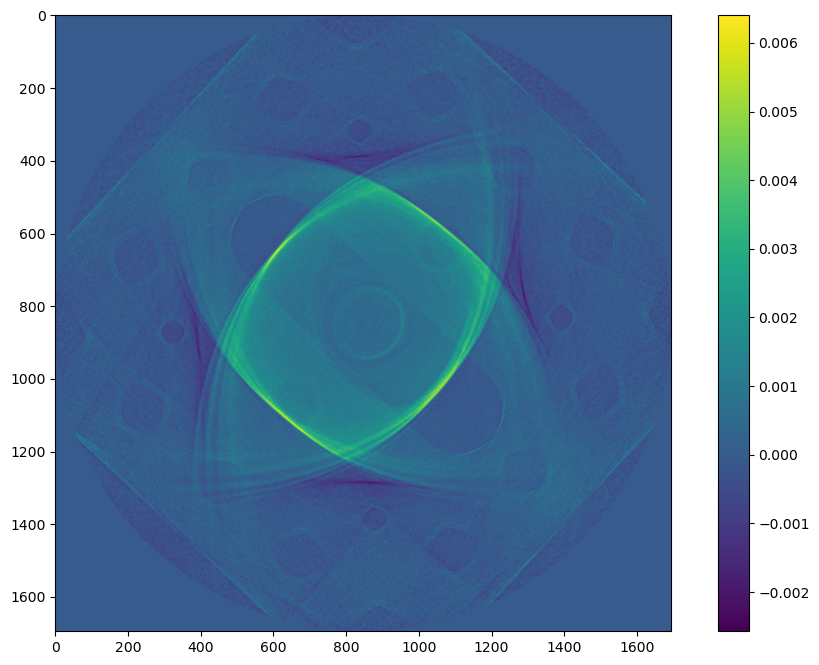

In [34]:
slice_num = None
# slice_num = 300
full_360 = True
# full_360 = False
#######################
if full_360:
    start_ang_idx = proj000_idx
    end_ang_idx = proj360_idx
    rot_center = rot_center_360
else:
    start_ang_idx = proj000_idx
    end_ang_idx = proj180_idx
    rot_center = rot_center_180
if slice_num is None:
    slice_num = int(proj_mlog_roi.shape[1]/2)
print("Center of rotation", rot_center)
t0 = timeit.default_timer()
rec_img1 = rec.gridrec_reconstruction(sino_mlog_to_recon[slice_num,start_ang_idx:end_ang_idx,:], rot_center, angles=ang_rad[start_ang_idx:end_ang_idx], apply_log=False,
                                      ratio=1.0,
                                      filter_name='shepp',
                                      pad=100,
                                      ncore=ncore
                                     )
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

## 2. FBP preview

Center of rotation 847.5
Time cost 0.009655765211209654 min


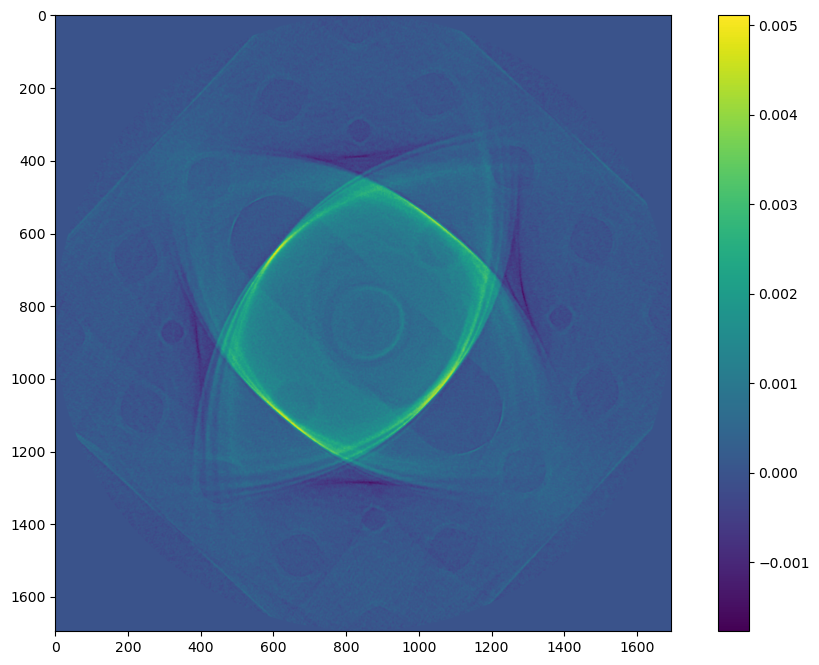

In [35]:
print("Center of rotation", rot_center)
t0 = timeit.default_timer()
rec_img1 = rec.fbp_reconstruction(sino_mlog_to_recon[slice_num,start_ang_idx:end_ang_idx,:], rot_center, angles=ang_rad[start_ang_idx:end_ang_idx], apply_log=False,
                                  ramp_win=None,
                                  filter_name='hann',
                                  pad=None,
                                  pad_mode='edge',
                                  ncore=ncore,
                                  gpu=False,
#                                   gpu=True, block=(16, 16), # Version error 7.8, current version 7.5
                                 )
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

## 3. ASTRA preview

Center of rotation 1099.8606524467468
Time cost 0.02526626021717675 min


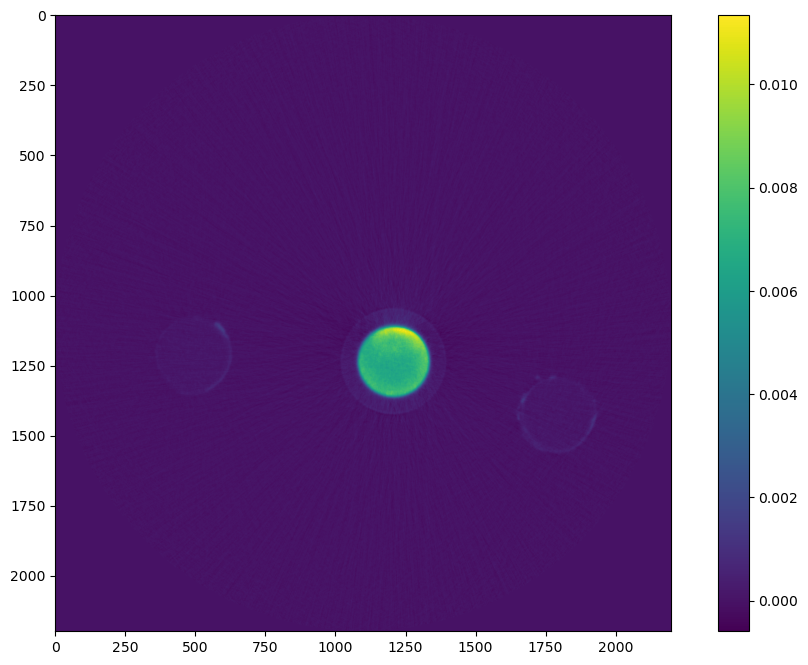

In [72]:
print("Center of rotation", rot_center)
# Reconstruction algorithms. 
# For CPU: 'FBP', 'SIRT', 'SART', 'ART', and CGLS'. 
# For GPU: 'FBP_CUDA', 'SIRT_CUDA', 'SART_CUDA', and 'CGLS_CUDA'.
t0 = timeit.default_timer()
rec_img1 = rec.astra_reconstruction(sino_mlog_to_recon[slice_num,start_ang_idx:end_ang_idx,:], rot_center, angles=ang_rad[start_ang_idx:end_ang_idx], apply_log=False,
                                    method='SIRT_CUDA',
                                    # method='SART_CUDA',
#                                     method='FBP_CUDA',
                                    ratio=1.0,
                                    filter_name='hann',
                                    pad=None,
                                    num_iter=300,
                                    ncore=ncore,
                                   )
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

## 4. svMBIR preview

Center of rotation 1086.4880981445312
Reconstructing axial size (rows,cols)=(2199,2199).
Found system matrix: /HFIR/CG1D/IPTS-33116/shared/autoreduce/svmbir/sysmatrix/770aa19df1c4160d0a3b.2Dsvmatrix
Time cost 6.286102365764479 min


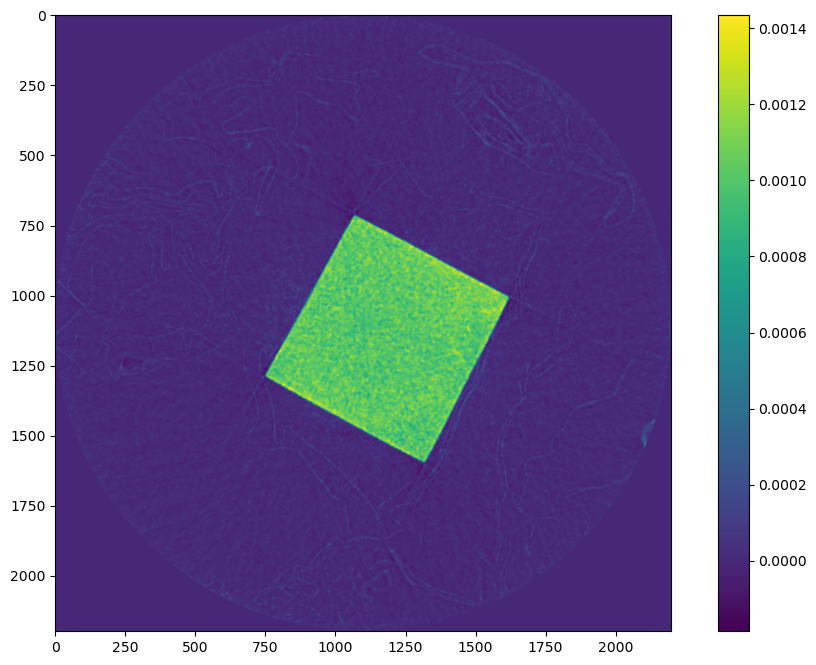

In [39]:
print("Center of rotation", rot_center)
T = 2.0
p = 1.2
sharpness = 0.0
snr_db = 30.0
center_offset= -(proj_mlog_to_recon.shape[2]/2 - rot_center)
t0 = timeit.default_timer()
recon_mbir = svmbir.recon(proj_mlog_to_recon[start_ang_idx:end_ang_idx,slice_num,:],
                          angles=np.array(ang_rad)[start_ang_idx:end_ang_idx], # In radians
                          weight_type='transmission', 
                          center_offset=center_offset, 
                          snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
                          positivity=False,
                          max_iterations=100,
                          num_threads= 112,
                          verbose=1,# verbose: display of reconstruction: 0 is minimum, 1 is regular
                          svmbir_lib_path = svmbir_path,
                         )
recon_mbir = np.fliplr(np.rot90(recon_mbir, k=1, axes=(1,2)))
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(recon_mbir[0])
plt.colorbar()
plt.show()

# Beam hardening correction (optional)

In [ ]:
###################### need to change start
idx = 1600
line_loc = 370
bh_q = 0.02
bh_n = 15
bh_opt = True
###################### need to change end
t0 = timeit.default_timer()
rec_img = rec.gridrec_reconstruction(sino_mlog_to_recon[idx], rot_center, angles=ang_rad, apply_log=False)
rec_img = rocku.crop(rec_img, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)

proj_norm_to_recon = np.exp(np.negative(proj_mlog_to_recon))
proj_norm_to_recon_bh_corr = corr.beam_hardening_correction(mat=proj_norm_to_recon, q=bh_q, n=bh_n, opt=bh_opt)
proj_mlog_to_recon_bh_corr = np.negative(np.log(proj_norm_to_recon_bh_corr))
sino_mlog_to_recon_bh_corr = np.moveaxis(proj_mlog_to_recon_bh_corr, 1, 0)
rec_img_bh_corr = rec.gridrec_reconstruction(sino_mlog_to_recon_bh_corr[idx], rot_center, angles=ang_rad, apply_log=False)
rec_img_bh_corr = rocku.crop(rec_img_bh_corr, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)

In [ ]:
start = (line_loc, 0)
end = (line_loc, rec_img.shape[1]-1)
profile = profile_line(rec_img, start, end)
profile_bh_corr = profile_line(rec_img_bh_corr, start, end)
fig, ax = plt.subplots(2, 2)
ax[0][0].set_title('Image')
ax[0][0].imshow(rec_img)
ax[0][0].plot([start[1], end[1]], [start[0], end[0]], 'r')
ax[0][1].set_title('Profile')
ax[0][1].plot(profile)
# ax[1][0].set_title('Image_BH')
ax[1][0].imshow(rec_img_bh_corr)
ax[1][0].plot([start[1], end[1]], [start[0], end[0]], 'r')
# ax[1][1].set_title('Profile_BH')
ax[1][1].plot(profile_bh_corr)
fig.show()
t1 = timeit.default_timer()
print("Time: {} mins".format((t1-t0)/60))

# Pick one method to recon the defined ring removed ROI

In [36]:
# pix_um = 15.97 * pixel_bin_size # um
# pix_um = 7.8 * pixel_bin_size # um
pix_um = 42 # um

recon_algo = 'gridrec'
# recon_algo = 'SIRT_CUDA'
# recon_algo = 'svmbir'

full_360 = True
# full_360 = False
##################################
slice_by_slice = False
if full_360:
    start_ang_idx = proj000_idx
    end_ang_idx = proj360_idx
    rot_center = rot_center_360
else:
    start_ang_idx = proj000_idx
    end_ang_idx = proj180_idx
    rot_center = rot_center_180
t0 = timeit.default_timer()
####################### tomopy algorithms (gridrec and fbp are faster than algotom) ##########################
if recon_algo in ['art', 'bart', 'fbp', 'gridrec',
                  'mlem', 'osem', 'ospml_hybrid', 'ospml_quad',
                  'pml_hybrid', 'pml_quad', 'sirt', 'tv', 'grad', 'tikh']:
    recon = tomopy.recon(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:], ang_rad[start_ang_idx:end_ang_idx], center=rot_center,
                         algorithm=recon_algo,
                         ncore=ncore, 
#                          nchunk=nchunk
                        )
################################################ algotom algorithms ##########################################
    #### ASTRA
if recon_algo in ['FBP', 'SIRT', 'SART', 'ART', 'CGLS', 'FBP_CUDA', 'SIRT_CUDA', 'SART_CUDA', 'CGLS_CUDA']:
    recon = rec.astra_reconstruction(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:], 
                                     rot_center, 
                                     angles=ang_rad[start_ang_idx:end_ang_idx],
                                     apply_log=False,
                                     method=recon_algo,
                                     ratio=1.0,
                                     filter_name='hann',
                                     pad=None,
                                     num_iter=300,
                                     ncore=ncore
                                    )
    recon = np.moveaxis(recon, 1, 0) 
    #### gridrec from algotom
if recon_algo == 'gridrec_algo':
    recon = rec.gridrec_reconstruction(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:],
                                       rot_center, 
                                       angles=ang_rad[start_ang_idx:end_ang_idx], 
                                       apply_log=False,
                                       ratio=1.0,
                                       filter_name='shepp',
                                       pad=100,
                                       ncore=ncore
                                      )
    recon = np.moveaxis(recon, 1, 0)
    #### FBP from algotom
if recon_algo == 'fbp_algo':
    recon = rec.fbp_reconstruction(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:], 
                                   rot_center, 
                                   angles=ang_rad[start_ang_idx:end_ang_idx], 
                                   apply_log=False,
                                   ramp_win=None,
                                   filter_name='hann',
                                   pad=None,
                                   pad_mode='edge',
                                   ncore=ncore,
                                   gpu=False,
#                                   gpu=True, block=(16, 16), # Version error 7.8, current version 7.5
                                  )
    recon = np.moveaxis(recon, 1, 0)
################################################### MBIR #####################################################
if recon_algo == 'svmbir':
    T = 2.0
    p = 1.2
    sharpness = 0.0
    snr_db = 30.0
    center_offset= -(proj_mlog_to_recon.shape[2]/2 - rot_center)
    recon = svmbir.recon(
        proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:],
#         proj_mlog_to_recon[:,595:605,:],
        angles=np.array(ang_rad)[start_ang_idx:end_ang_idx], # In radians
        weight_type='transmission', 
        center_offset=center_offset, 
        snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
        positivity=False,
        max_iterations=50,
        num_threads= 112,
        verbose=1,# verbose: display of reconstruction: 0 is minimum, 1 is regular
        svmbir_lib_path = svmbir_path,
    )
    recon = np.fliplr(np.rot90(recon, k=1, axes=(1,2)))
##################################
if pix_um is not None:
    pix_cm = pix_um/10000
    recon = recon/pix_cm
    history_dict = rocku.log(history_dict, 'pixel_size_um', pix_um)
    history_dict = rocku.log(history_dict, 'recon_unit', 'cm-1')
    recon_unit = 'cm-1'
else:
    history_dict = rocku.log(history_dict, 'recon_unit', 'px-1')
    recon_unit = 'px-1'
history_dict = rocku.log(history_dict, 'start_ang_idx', start_ang_idx)
history_dict = rocku.log(history_dict, 'end_ang_idx', end_ang_idx)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)
history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))

Time cost 0.0538220809151729 min


# Crop reconstructed volume

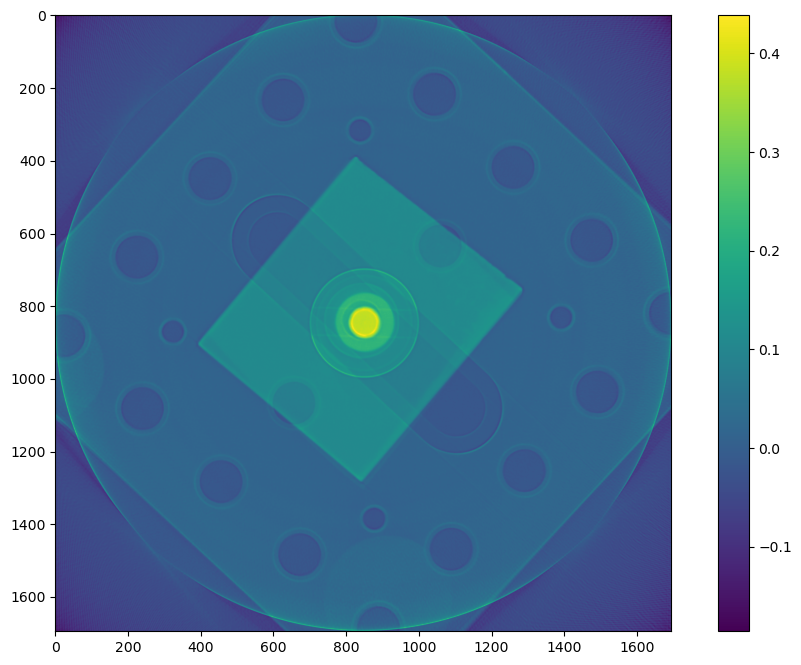

In [37]:
recon_max = np.mean(recon, axis=0)
plt.imshow(recon_max)#, vmax=2)
plt.colorbar()
plt.show()

In [38]:
###################### need to change start
### Define crop roi
# recon_crop = True
recon_crop = False

recon_crop_left = 850
recon_crop_right = 1470
recon_crop_top = 960
recon_crop_bottom = 1580
###################### need to change end
recon_max_crop = rocku.crop(recon_max, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
recon_crop_roi_dict = {
    'left': recon_crop_left,
    'right': recon_crop_right,
    'top': recon_crop_top,
    'bottom': recon_crop_bottom
}

if recon_crop:
    print("Recon ROI:")
    plt.imshow(recon_max_crop)#, vmax=2)
    plt.colorbar()
    plt.show()

In [39]:
# Apply cropping to the whole recon volume and save info to h5
recon = rocku.crop(recon, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
history_dict = rocku.log(history_dict, 'recon_crop', recon_crop)
if recon_crop:
    history_dict = rocku.log(history_dict, 'recon_crop_roi', recon_crop_roi_dict)

# Export recon files

In [40]:
################ change save path for your own
num_proj = len(ang_rad)
save_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/"
# name_str = None
name_str = 'lamino'
############################################################
if name_str is not None:
    save_name_str = "_".join([sample_name, name_str, "{}proj".format(num_proj), recon_algo])# + "_roi"
else:
    save_name_str = "_".join([sample_name, "{}proj".format(num_proj), recon_algo])# + "_roi"
save_to = save_loc + save_name_str
# save_to =  + sample_name + "_{}proj_".format(num_proj) + recon_algo
# save_to = "/netdisk/y9z/IPTS-"+ipts+"/recon/" + sample_name
print(save_to)
dxchange.write_tiff_stack(recon, fname=save_to + "/recon", overwrite=True, digit=4)

/HFIR/CG1D/IPTS-32340/shared/processed_data/rockit/2024_03_17_laminography_S2_lamino_735proj_gridrec


# Export to HDF5

In [41]:
history_dict

{'crop': True,
 'crop_roi_dict': {'left': 200, 'right': -1, 'top': 65, 'bottom': -110},
 'gamma_filter': True,
 'gamma_diff': 20,
 'normalization': True,
 'pixel_bin_size': 1,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi_dict': {'left': 0,
  'right': 600,
  'top': 1400,
  'bottom': -1},
 'minus_log': True,
 'tilt_corr_used': 'neutompy',
 'define_roi': True,
 'define_roi_dict': {'left': 76, 'right': -76, 'top': 0, 'bottom': 1100},
 'rot_center_180': 833.75,
 'rot_center_360': 847.5,
 'rot_center': 847.5,
 'tilt_corr_theta': -0.3869136820536429,
 'tilt_corr_shift': 76,
 'ring_removal': 'bm3dgpu',
 'pixel_size_um': 42,
 'recon_unit': 'cm-1',
 'start_ang_idx': 0,
 'end_ang_idx': 733,
 'recon_algo': 'gridrec',
 'recon_crop': False}

In [42]:
# output_hdf5_dir = "/netdisk/y9z/IPTS-"+ipts+"/hdf5/"
# output_hdf5_dir = "/netdisk/y9z/CG1D/IPTS-"+ipts+"/rockit/hdf5/"
output_hdf5_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
output_hdf5 = output_hdf5_dir + save_name_str + '.h5'
print(output_hdf5)

/HFIR/CG1D/IPTS-32340/shared/autoreduce/hdf5/2024_03_17_laminography_S2_lamino_735proj_gridrec.h5


In [43]:
if not os.path.exists(output_hdf5_dir):
    os.mkdir(output_hdf5_dir)
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo/raw_ref')
    f.create_dataset('tomo/raw_ref/proj_min', data=proj_min)
    f.create_dataset('tomo/raw_ref/ob_min', data=ob_min)
    f.create_dataset('tomo/raw_ref/dc_max', data=dc_max)
    f.create_dataset('tomo/raw_ref/proj_crop_roi_min', data=proj_crop_min)
    if fluc_corr:
        f.create_dataset('tomo/raw_ref/fluc_corr_roi_min', data=bg_min)
    f.create_group('tomo/proj')
    f.create_dataset('tomo/proj/proj_norm_pre_tilt', data=proj_norm)
    f.create_dataset('tomo/proj/proj_mlog_pre_tilt', data=proj_mlog)
    f.create_dataset('tomo/proj/proj_mlog_pre_ring', data=proj_mlog_roi)
    f.create_dataset('tomo/proj/proj_mlog_to_recon', data=proj_mlog_to_recon)
    f.create_group('tomo/sino')
    f.create_dataset('tomo/sino/sino_mlog_pre_tilt', data=sino_mlog)
    f.create_dataset('tomo/sino/sino_mlog_pre_ring', data=sino_mlog_roi)
    f.create_dataset('tomo/sino/sino_mlog_to_recon', data=sino_mlog_to_recon)
    f.create_group('tomo/info')
    f.create_dataset('tomo/info/ang_deg', data=ang_deg, dtype=np.float32)
    f.create_dataset('tomo/info/ang_rad', data=ang_rad, dtype=np.float64)
    f.create_dataset('tomo/info/proj000_idx', data=(proj000_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/proj180_idx', data=(proj180_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/proj360_idx', data=(proj360_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/fname', data=fname_sorted)
    f.create_group('tomo/recon')
    f.create_dataset('tomo/recon/history', data=(str(history_dict),))
    f.create_dataset('tomo/recon/recon_unit', data=(recon_unit,))
    if not slice_by_slice:
        f.create_dataset('tomo/recon/recon_volume', data=recon)

In [ ]:
os.listdir(svmbir_path)